In [1]:
import os
import pickle
from easydict import EasyDict

import cv2
import matplotlib.pyplot as plt
import nmslib
import numpy as np
import torch
from torchvision import transforms
from tqdm.auto import tqdm

from demonstration.utils.dataset import RetrievalDataset
from demonstration.utils.visualization import prepare_img, plot_topn

## Подготовка эмбеддингов

In [2]:
cfg = EasyDict()
cfg.eval_batch_size = 1

# dataset
cfg.data_dir = r'C:\Users\khanz\PycharmProjects\inno_ds\final_project\data\demo'

# checkpoints
cfg.checkpoints_dir = r'C:\Users\khanz\PycharmProjects\inno_ds\final_project\data\demo\models'

# embeddings paths
cfg.embeddings_path = r'C:\Users\khanz\PycharmProjects\inno_ds\final_project\data\demo\embeddings\demo'

# models
cfg.models = {
    'baseline': 'FIN-59_traced_best.pt',
    'divide and conquer': 'FIN-72_traced_with_norm.pt',
    'cross-batch memory': 'FIN-71_traced_best.pt'
}

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
test_preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = RetrievalDataset(cfg.data_dir, 'demo', transforms=test_preprocess)
dataloader = torch.utils.data.dataloader.DataLoader(dataset, shuffle=False, batch_size=cfg.eval_batch_size, drop_last=False)

In [5]:
def get_model(model_name):
    model_path = cfg.models[model_name]
    model = torch.jit.load(os.path.join(cfg.checkpoints_dir, model_path), map_location=device)
    return model

In [6]:
@torch.no_grad()
def get_embeddings(loader, model):
    all_embed, all_labels, images = [], [], []
    model.eval()
    for i, (batch_data, batch_labels) in enumerate(tqdm(loader, desc='Get embeddings')):
        output = model(batch_data.to(device))
        all_embed.append(output.detach().cpu().view(-1, output.size(-1)))
        all_labels.extend(batch_labels)
    return {
        'embeddings': torch.vstack(all_embed).numpy(),
        'labels': np.vstack(all_labels),
    }

In [7]:
def evaluate(model_name, loader, k=5, indices=None, size=3):

    model = get_model(model_name)
    embeddings_path = cfg.embeddings_path + f'/{model_name}_{cfg.models[model_name].split(".")[0]}.pickle'

    if not os.path.exists(embeddings_path):
        data = get_embeddings(loader, model)
        with open(embeddings_path, 'wb') as f:
            pickle.dump(data, f)
    else:
        with open(embeddings_path, 'rb') as f:
            data = pickle.load(f)

    all_embed, all_labels = data['embeddings'], data['labels']
    queries_ind = np.random.randint(0, len(all_embed), size=size) if indices is None else indices
    retrieval_ind = np.setdiff1d(np.arange(len(all_embed)), queries_ind)
    queries, queries_labels = all_embed[queries_ind], all_labels[queries_ind]
    retrieval_set, retrieval_labels = all_embed[retrieval_ind], all_labels[retrieval_ind]

    index = nmslib.init(method='hnsw', space='l2')
    index.addDataPointBatch(retrieval_set)
    index.createIndex(print_progress=True)
    ids, distances = list(zip(*index.knnQueryBatch(queries, k=k)))
    ids = np.asarray(ids)
    distances = np.asarray(distances)

    queries = [prepare_img(loader.dataset[i][0]) for i in queries_ind]
    retrieval_set = [[prepare_img(loader.dataset[retrieval_ind[ids[i, j]]][0]) for j in range(len(ids[i]))] for i in range(len(ids))]
    plot_topn(queries, retrieval_set, distances, title=model_name)

In [8]:
size = 3
indices = np.random.randint(0, len(dataloader.dataset), size=size)

### Baseline

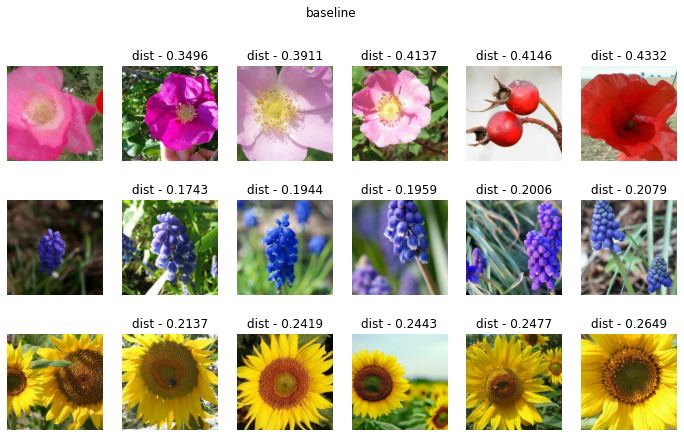

In [9]:
evaluate('baseline', dataloader, k=5, indices=indices)

### Divide and Conquer

Get embeddings:   0%|          | 0/7382 [00:00<?, ?it/s]

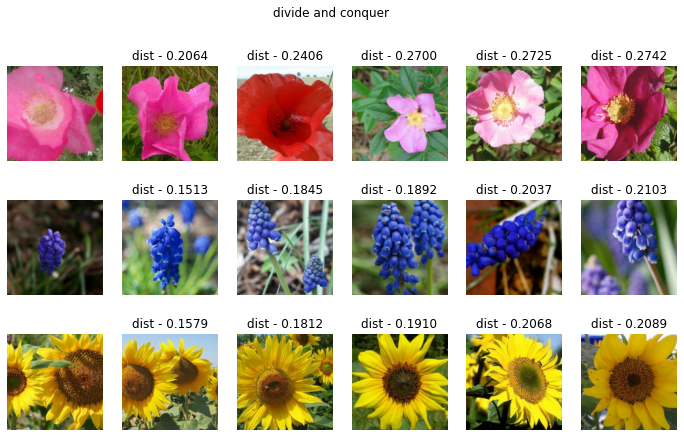

In [10]:
evaluate('divide and conquer', dataloader, k=5, indices=indices)

### Cross-batch Memory

Get embeddings:   0%|          | 0/7382 [00:00<?, ?it/s]

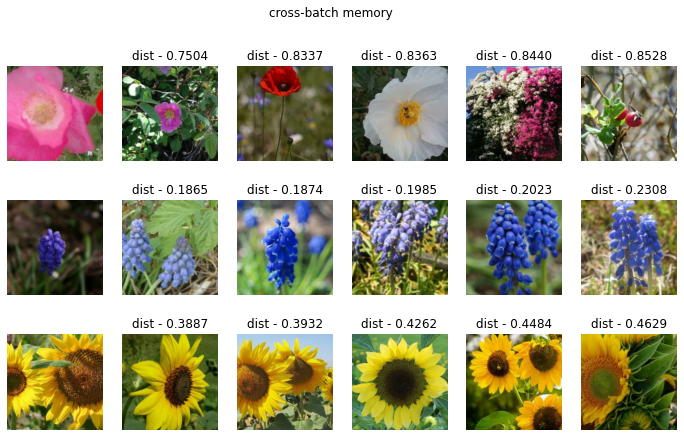

In [11]:
evaluate('cross-batch memory', dataloader, k=5, indices=indices)